In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

  Activating project at `~/Research/Bump10MSun`


In [21]:
using Bump10MSun
using HDF5
using LaTeXStrings
using Printf
using MCMCChains
using MCMCChainsStorage
using StatsBase
using StatsPlots

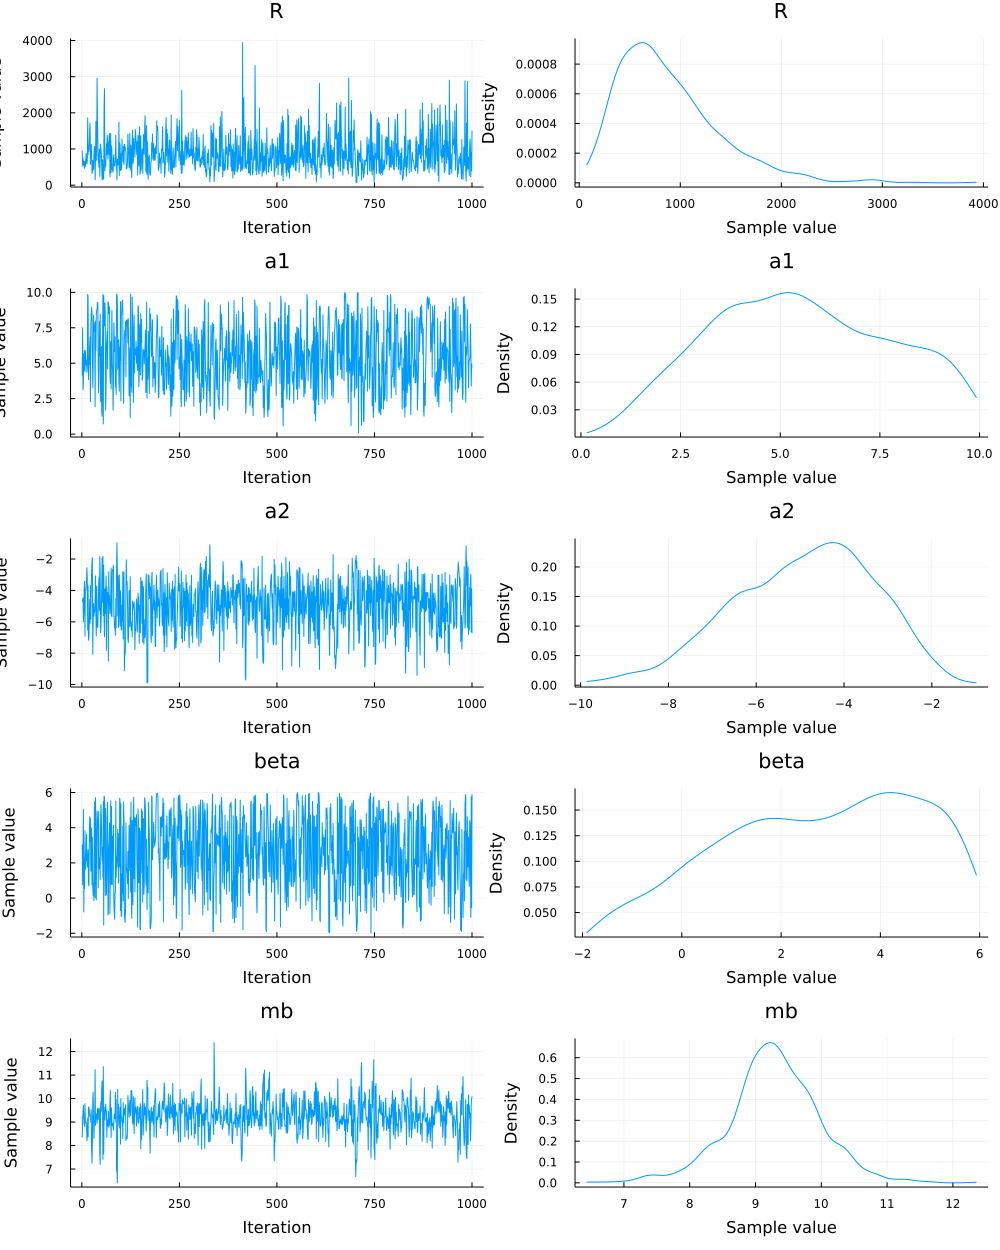

In [3]:
trace = h5open(joinpath(@__DIR__, "..", "chains", "chains.h5"), "r") do f
    read(f, Chains)
end
var_names = [:a1, :a2, :mb, :beta, :R]
plot(trace[var_names])

In [4]:
dNdm1dm2 = map(trace[:a1], trace[:a2], trace[:mb], trace[:beta], trace[:R]) do a1, a2, mb, beta, R
    ldN = make_log_dN(a1, a2, mb, beta)
    (m1, m2) -> R*exp(ldN(m1,m2))
end
dNdm1 = map(trace[:a1], trace[:a2], trace[:mb], trace[:beta], trace[:R]) do a1, a2, mb, beta, R
    dN = make_dNdm1(a1, a2, mb, beta)
    m1 -> R*dN(m1)
end
dNdm2 = map(trace[:a1], trace[:a2], trace[:mb], trace[:beta], trace[:R]) do a1, a2, mb, beta, R
    dN = make_dNdm2(a1, a2, mb, beta)
    m2 -> R*dN(m2)
end;

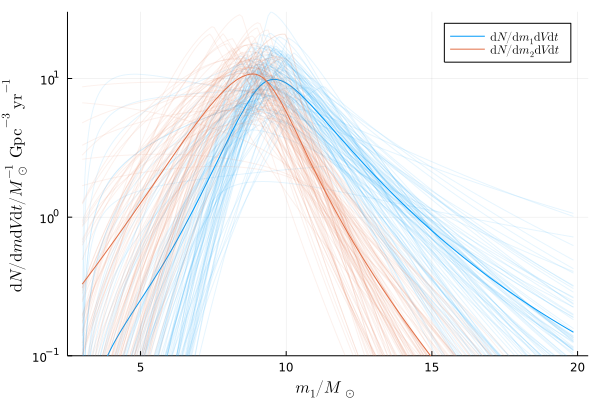

In [17]:
ms = exp.(log(mlow):0.01:log(mhigh))
dN1_mean = zeros(length(ms))
dN2_mean = zeros(length(ms))

p = plot()

for dN in dNdm1
    dN1_mean = dN1_mean .+ dN.(ms)
end
dN1_mean = dN1_mean ./ length(dNdm1)
p = plot!(ms, dN1_mean, yscale=:log10, ylims=(0.1, Inf), xlabel=L"m_1 / M_\odot", ylabel=L"\mathrm{d} N / \mathrm{d}m \mathrm{d} V \mathrm{d} t / M_\odot^{-1}\, \mathrm{Gpc}^{-3}\, \mathrm{yr}^{-1}", label=L"\mathrm{d}N/\mathrm{d}m_1\mathrm{d}V\mathrm{d}t")
for _ in 1:100
    p = plot!(ms, sample(dNdm1).(ms), color=1, alpha=0.1, label=nothing)
end

for dN in dNdm2
    dN2_mean = dN2_mean .+ dN.(ms)
end
dN2_mean = dN2_mean ./ length(dNdm1)
p = plot!(ms, dN2_mean, color=2, yscale=:log10, ylims=(0.1, Inf), xlabel=L"m_1 / M_\odot", ylabel=L"\mathrm{d} N / \mathrm{d}m \mathrm{d} V \mathrm{d} t / M_\odot^{-1}\, \mathrm{Gpc}^{-3}\, \mathrm{yr}^{-1}", label=L"\mathrm{d}N/\mathrm{d}m_2 \mathrm{d}V\mathrm{d}t")
for _ in 1:100
    p = plot!(ms, sample(dNdm2).(ms), color=2, alpha=0.1, label=nothing)
end

p

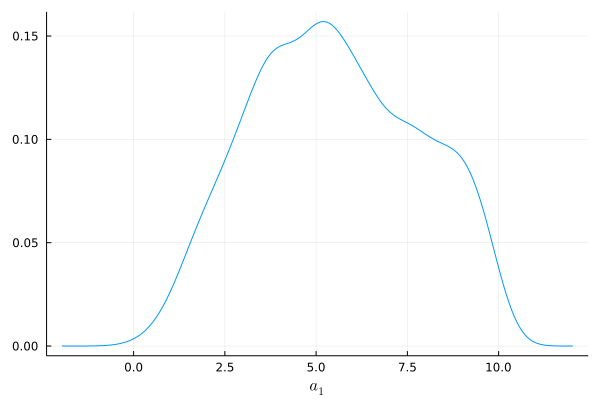

In [18]:
@df trace density(:a1, xlabel=L"a_1", label=nothing)

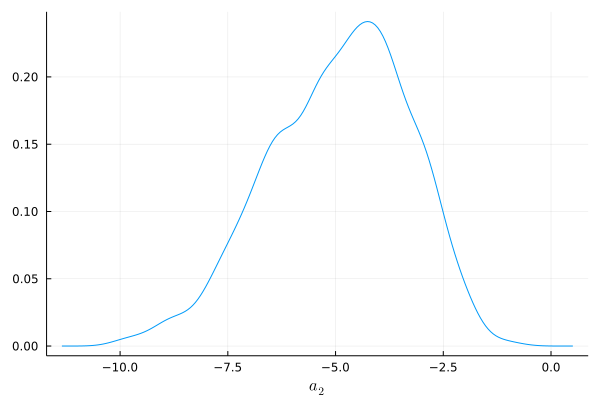

In [19]:
@df trace density(:a2, xlabel=L"a_2", label=nothing)

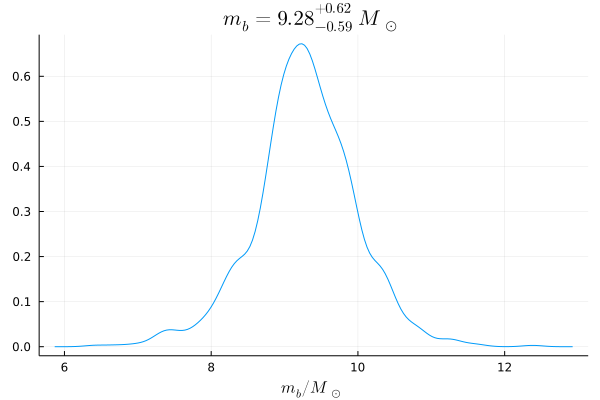

In [23]:
x = vec(trace[:mb])
l = quantile(x, 0.16)
m = quantile(x, 0.5)
h = quantile(x, 0.84)

@df trace density(:mb, xlabel=L"m_b / M_\odot", label=nothing)
title!(@sprintf("\$m_b = %.2f^{+%.2f}_{-%.2f} \\, M_\\odot\$", m, h-m, m-l))